# The Hedonic Detector and Depression

# Loading the Data

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

KeyboardInterrupt: ignored

In [11]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msgn

pd.options.display.max_columns = 200

data = pd.read_excel('Data Input (5) (1).xlsx', encoding='latin')

data.head(1)

,Id,Gender,Age,PANAS_1,PANAS_2,PANAS_3,PANAS_4,PANAS_5,PANAS_6,PANAS_7,PANAS_8,PANAS_9,PANAS_10,PANAS_11,PANAS_12,PANAS_13,PANAS_14,PANAS_15,PANAS_16,PANAS_17,PANAS_18,PANAS_19,PANAS_20,DASS_1_s,DASS_2_a,DASS_3_d,DASS_4_a,DASS_5_d,DASS_6_s,DASS_7_a,DASS_8_s,DASS_9_a,DASS_10_d,DASS_11_s,DASS_12_s,DASS_13_d,DASS_14_s,DASS_15_a,DASS_16_d,DASS_17_d,DASS_18_s,DASS_19_a,DASS_20_a,DASS_21_d,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10,word_11,word_12,word_13,word_14,word_15,word_16,word_17,word_18,word_19,word_20,word_21,word_22,word_23,word_24,word_25,word_26,word_27,word_28,word_29,word_30,word_31,word_32,word_33,word_34,word_35,word_36,word_37,word_38,word_39,word_40,word_41,word_42,word_43,word_44,word_45,word_46,word_47,word_48,word_49,word_50,word_51,word_52,word_53,word_54,word_55,word_56,word_57,word_58,word_59,word_60
0,1205001,m,24,2,1,1,1,2,1,1,1,3,2,1,3,1,2,1,2,3,1,2,1,3,2,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,5,4,5,4,5,6,4,4,6,5,5,5,5,2,7,6,5,6,7,6,6,5,4,5,5,5,6,5,3,6,5,5,6,4,4,5,6,6,6,6,5,4,4,4,6,7,6,6,7,8,6,5,6,5,6,5,6,6,5,4


In [12]:
data.shape

(249, 104)

# Data Integrity

In [13]:
# No Missing Values
data.isnull().sum().sum()

0

In [14]:
# Only non numeric Columns
data.select_dtypes(include='object').head()

,Id,Gender
0,1205001,m
1,1205002,m
2,1205003,f
3,1205004,m
4,1205005,m


# Data Preparation

### Scoring the PANAS scale

The PANAS scale comprises two distinct scales, one for positive and one for negative affect. These are summed separately, to produce two scores, for positive and negative affect, respectively.

In [0]:
PANAS_positive = [1, 3, 5, 9, 10, 12, 14, 16, 17, 19]
PANAS_negative = [2,4,6,7,8,11,13,15,18,20]


data['PANAS_positive'] = data.apply(lambda x: sum(x['PANAS_'+str(i)] for i in PANAS_positive), axis=1)
data['PANAS_negative'] = data.apply(lambda x: sum(x['PANAS_'+str(i)] for i in PANAS_negative), axis=1)


### Scoring the DEPRESSION, ANXIETY and STRESS subscales of the DASS

Items for the depression, anxiety, and stress subscales are summed separately, to produce three scores, one for each subscale.

In [0]:
data['DEPRESSION_score'] = data.apply(lambda x: sum(x[col] for col in data.columns if col.endswith('_d')), axis=1)
data['ANX_score'] = data.apply(lambda x: sum(x[col] for col in data.columns if col.endswith('_a')), axis=1)
data['STRESS_score'] = data.apply(lambda x: sum(x[col] for col in data.columns if col.endswith('_s')), axis=1)


### Removing the DASS-21 and PANAS items from our data

After scores have been computed, we no longer retain the separate items.

In [0]:
# Dropping DASS items
data.drop([col for col in data.columns if col.endswith('_d') or col.endswith('_a') or col.endswith('_s')], axis=1, inplace=True)

In [0]:
# Dropping PANAS items
data.drop([col for col in data.columns if col.startswith('PANAS') and col[-1].isdigit()], axis=1, inplace=True)

### Column selection and Gender coding

Participant ID was dropped as it was not needed for the analyses. Gender was mapped to a dummy variable for analysis, male coded as 1, and female coded as 0.

In [0]:
# removing participant id
data.drop(['Id'], axis=1, inplace=True)

In [0]:
data['Gender'] = data['Gender'].map({'m':1, 'M':1, 'f':0, 'F':0})

In [0]:
data.head(4)

,Gender,Age,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10,word_11,word_12,word_13,word_14,word_15,word_16,word_17,word_18,word_19,word_20,word_21,word_22,word_23,word_24,word_25,word_26,word_27,word_28,word_29,word_30,word_31,word_32,word_33,word_34,word_35,word_36,word_37,word_38,word_39,word_40,word_41,word_42,word_43,word_44,word_45,word_46,word_47,word_48,word_49,word_50,word_51,word_52,word_53,word_54,word_55,word_56,word_57,word_58,word_59,word_60,PANAS_positive,PANAS_negative,DEPRESSION_score,ANX_score,STRESS_score
0,1,24,5,4,5,4,5,6,4,4,6,5,5,5,5,2,7,6,5,6,7,6,6,5,4,5,5,5,6,5,3,6,5,5,6,4,4,5,6,6,6,6,5,4,4,4,6,7,6,6,7,8,6,5,6,5,6,5,6,6,5,4,22,10,1,2,5
1,1,21,4,3,6,3,7,2,6,5,6,7,4,3,6,8,5,5,4,2,4,5,4,8,5,5,4,4,3,3,4,6,5,5,5,7,7,7,8,6,5,3,4,4,4,6,5,7,4,6,7,4,6,5,4,4,4,4,5,6,4,5,31,19,4,6,8
2,0,22,3,5,3,6,2,5,3,7,6,8,2,7,7,2,7,8,6,3,7,6,5,7,2,4,2,7,4,2,7,8,2,4,8,8,4,6,7,3,7,1,3,7,4,3,7,8,2,7,2,2,2,8,7,5,8,3,1,8,8,7,44,13,2,17,19
3,1,21,2,2,6,3,4,5,7,5,6,6,6,3,4,7,6,5,5,4,3,3,5,7,4,3,2,5,2,3,3,5,5,5,6,6,7,7,7,5,5,4,5,5,4,4,3,6,7,5,4,4,6,4,3,3,5,3,2,4,5,5,34,13,3,2,8


# Comparison to normal population

In [0]:
words=['salad','skull','bake','stomach','nurse','column','poster','curtains','engine','jelly','whistle','cliff',
       'cork','lottery','sphere','bench','statue','passage','hairpin','kettle','corridor','legend','trumpet','fish',
       'iron','seat','razor','shadow','finger','grass','corner','bowl','dress','cook','tennis','coin','autumn',
       'stove','pencil','dirt','umbrella','paint','scissors','lawn','radiator','voyage','rain','queen','tool',
       'knot','storm','hotel','egg','glass','arm','locker','hammer','key','fabric','paper']

### Loading the normative mean and SD data from ANEW

In [0]:
valence_data_male = pd.read_csv('valence_data_male.csv')
valence_data_female = pd.read_csv('valence_data_female.csv')

valence_data_male.head(1)

,word,word_id,valence_mean,valence_sd,arousal_mean,arousal_sd,dominance_mean,dominance_sd,word_frequency
0,abduction,621,3.19,1.94,4.95,1.99,4.25,2.05,1


In [0]:
# Restricting ourselves to only the 60 words in the study
valence_data_male = valence_data_male[valence_data_male['word'].apply(lambda x: x in words)]
valence_data_female = valence_data_female[valence_data_female['word'].apply(lambda x: x in words)]


In [0]:
valence_data_male.head(1)

,word,word_id,valence_mean,valence_sd,arousal_mean,arousal_sd,dominance_mean,dominance_sd,word_frequency
46,arm,642,5.5,1.79,4.4,2.74,5.05,2.01,94


In [0]:
# We need to map the academic 9 point scale to an 8 point scale. 
valence_data_male.loc[:,'valence_mean':'dominance_sd'] = valence_data_male.loc[:,'valence_mean':'dominance_sd'].applymap(lambda x: x/9*8)
valence_data_female.loc[:,'valence_mean':'dominance_sd'] = valence_data_female.loc[:,'valence_mean':'dominance_sd'].applymap(lambda x: x/9*8)

In [0]:
# Selecting only the word, valence_mean and valence_sd columns
valence_data_male = valence_data_male[['word','valence_mean','valence_sd']]
valence_data_female = valence_data_female[['word','valence_mean','valence_sd']]

In [0]:
# Setting the words as the index
valence_data_male.set_index('word', inplace=True)
valence_data_female.set_index('word', inplace=True)

In [0]:
# Normalizing the scores (including gender considerations)
df = data.rename(columns = {'word_{}'.format(i+1):word for i, word in enumerate(words)})

for word in words:
    mean_male, sd_male = valence_data_male.loc[word][['valence_mean','valence_sd']]    
    mean_female, sd_female = valence_data_female.loc[word][['valence_mean','valence_sd']]
    df[word] = df.apply(lambda x: (x[word]-mean_male)/sd_male if x['Gender']==1 else (x[word]-mean_female)/sd_female, axis=1)

In [0]:
df.head()

,Gender,Age,salad,skull,bake,stomach,nurse,column,poster,curtains,engine,jelly,whistle,cliff,cork,lottery,sphere,bench,statue,passage,hairpin,kettle,corridor,legend,trumpet,fish,iron,seat,razor,shadow,finger,grass,corner,bowl,dress,cook,tennis,coin,autumn,stove,pencil,dirt,umbrella,paint,scissors,lawn,radiator,voyage,rain,queen,tool,knot,storm,hotel,egg,glass,arm,locker,hammer,key,fabric,paper,PANAS_positive,PANAS_negative,DEPRESSION_score,ANX_score,STRESS_score
0,1,24,0.150000,-0.048077,-0.556000,-0.220588,-0.401515,1.538462,-0.484694,-0.862069,0.993289,-0.128866,-0.103306,0.298206,0.347015,-3.082759,2.108696,1.634328,0.635802,1.033898,1.576433,1.444444,1.476562,-0.615702,-0.861842,-0.259009,0.387640,0.966981,0.862069,1.125000,-1.348592,0.708661,0.981061,1.309524,0.888889,-1.270492,-0.654028,-0.058190,0.448087,0.870748,2.164179,1.218750,0.283333,-0.428571,-1.333333,-0.873563,1.654412,0.939873,0.526515,0.870370,1.915323,3.181818,0.659091,-0.741135,1.006135,0.654070,0.698324,0.424528,1.600000,0.891720,0.288194,-0.605839,22,10,1,2,5
1,1,21,-0.600000,-0.588942,0.344000,-0.772059,0.734848,-2.788462,0.663265,1.077586,0.993289,2.190722,-1.033058,-0.710762,1.186567,1.572414,0.152174,0.794776,-0.753086,-2.779661,-0.573248,0.402778,-0.281250,2.173554,-0.121711,-0.259009,-0.876404,-0.094340,-0.800493,-1.125000,-0.556338,0.708661,0.981061,1.309524,-0.247475,1.495902,0.945498,0.911638,1.677596,0.870748,0.485075,-0.539062,-0.466667,-0.428571,-1.333333,1.712644,0.827206,0.939873,-0.325758,0.870370,1.915323,0.034965,0.659091,-0.741135,-0.374233,0.000000,-0.558659,-0.283019,0.700000,0.891720,-0.493056,0.215328,31,19,4,6,8
2,0,22,-1.517964,1.081169,-1.298544,0.962264,-1.629630,0.674242,-1.179245,3.227273,1.349593,2.099379,-2.888000,1.820313,2.771277,-1.761506,4.990566,2.959184,2.491803,-1.104430,2.018382,2.083333,0.710784,0.996599,-2.653846,-0.831325,-2.223301,3.039326,-0.078603,-1.545455,1.775862,1.679487,-1.901786,-0.702703,1.537931,1.200000,-0.882353,0.302013,0.618943,-0.703390,3.891304,-1.745283,-1.044910,1.013889,-0.351563,-2.132184,4.628788,1.338028,-1.066667,0.523649,-2.094488,-1.976923,-1.053333,1.860963,1.252551,0.646789,2.037634,-2.331461,-3.587963,1.842424,3.731959,2.407895,44,13,2,17,19
3,1,21,-2.100000,-1.129808,0.344000,-0.772059,-0.969697,0.456731,1.237245,1.077586,0.993289,1.030928,0.826446,-0.710762,-0.492537,0.796552,1.130435,0.794776,0.635802,-0.872881,-1.289809,-1.680556,0.597656,1.243802,-0.861842,-1.272523,-3.404494,0.966981,-1.354680,-1.125000,-1.348592,-0.177165,0.981061,1.309524,0.888889,0.573770,0.945498,0.911638,1.062842,0.105442,0.485075,0.046875,0.283333,0.301948,-1.333333,-0.873563,-0.827206,0.227848,0.952652,-0.171296,-0.806452,0.034965,0.659091,-1.539007,-1.064417,-0.654070,0.069832,-0.990566,-2.000000,-0.541401,0.288194,0.215328,34,13,3,2,8
4,1,21,1.650000,-0.588942,1.244000,-0.220588,-0.969697,-0.625000,0.089286,-2.801724,1.748322,2.190722,-0.103306,0.802691,-0.492537,0.020690,-0.826087,1.634328,2.024691,0.080508,1.576433,1.444444,-0.281250,1.243802,1.358553,0.754505,0.387640,2.028302,0.307882,2.250000,1.028169,2.480315,0.128788,3.095238,3.161616,2.418033,1.478673,0.911638,1.677596,0.870748,0.485075,1.218750,-1.216667,1.032468,1.010417,3.005747,2.481618,1.651899,0.952652,-1.212963,0.100806,1.608392,-0.363636,0.854610,1.006135,0.654070,0.698324,-0.283019,1.600000,0.175159,1.069444,-0.605839,35,12,1,1,2


In [0]:
valence_data_male.loc['salad']

valence_mean    4.800000
valence_sd      1.333333
Name: salad, dtype: float64

###Splitting words into negative, neutral and positive

In [0]:
word_categ = {'salad':'pos','skull':'neg','bake':'pos','stomach':'neg','nurse':'pos',
              'column':'neut','poster':'neut','curtains':'neg','engine':'neut','jelly':'pos',
              'whistle':'pos','cliff':'neg','cork':'neut','lottery':'pos','sphere':'neut','bench':'neg',
              'statue':'neut','passage':'neut','hairpin':'neut','kettle':'neut','corridor':'neg',
              'legend':'pos','trumpet':'pos','fish':'pos','iron':'neg','seat':'neg','razor':'neg',
              'shadow':'neg','finger':'neut','grass':'pos','corner':'neg','bowl':'neut','dress':'pos',
              'cook':'pos','tennis':'pos','coin':'pos','autumn':'pos','stove':'neg','pencil':'neut',
              'dirt':'neg','umbrella':'neut','paint':'pos','scissors':'neg','lawn':'neut','radiator':'neg',
              'voyage':'pos','rain':'neg','queen':'pos','tool':'neut','knot':'neg','storm':'neg','hotel':'pos',
              'egg':'neut','glass':'neg','arm':'neut','locker':'neut','hammer':'neg','key':'pos','fabric':'neut',
              'paper':'neut'}

In [0]:
valence_data_male

,valence_mean,valence_sd
word,,
arm,4.888889,1.591111
autumn,5.271111,1.626667
bake,5.617778,1.111111
bench,4.053333,1.191111
bowl,4.266667,0.560000
cliff,4.408889,1.982222
coin,5.120000,2.062222
column,4.577778,0.924444
cook,5.377778,1.084444


In [0]:
def helper(df, thresholds, male_valences=valence_data_male, female_valences=valence_data_female):
    df_male = df[df['Gender']==1]
    df_female = df[df['Gender']==0]
    
    ans_male_df = df[[word for word in words if 
                      thresholds[0] <= male_valences.loc[word]['valence_mean'] <= thresholds[1]]]
    
    ans_female_df = df[[word for word in words if 
                        thresholds[0] <=female_valences.loc[word]['valence_mean'] <= thresholds[1]]]
    
    ans_df = pd.concat([ans_male_df, ans_female_df], axis=0, ignore_index=True)
    return ans_df

In [0]:
df_neg = helper(df,  [0,   4.499999])
df_neut = helper(df, [4.5, 4.99999999])
df_pos = helper(df,  [5,   100])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  # This is added back by InteractiveShellApp.init_path()


df_neg = df[[word for word in words if word_categ[word]=='neg']]
df_neut = df[[word for word in words if word_categ[word]=='neut']]
df_pos = df[[word for word in words if word_categ[word]=='pos']]

In [0]:
df_neg.head(1)

,bench,bowl,cliff,corner,corridor,curtains,dirt,glass,hammer,iron,knot,locker,radiator,rain,razor,scissors,seat,shadow,skull,stomach,storm,stove,tool
0,1.634328,1.309524,0.298206,0.981061,1.476562,-0.862069,1.21875,0.65407,1.6,NaN,3.181818,0.424528,1.654412,NaN,0.862069,NaN,0.966981,1.125,-0.048077,-0.220588,NaN,NaN,NaN


In [0]:
df_neut.head(1)

,arm,bowl,column,cork,egg,engine,fabric,finger,hairpin,hotel,iron,jelly,kettle,key,lawn,locker,paint,paper,passage,pencil,poster,rain,salad,scissors,seat,sphere,statue,storm,stove,tool,umbrella
0,0.698324,NaN,1.538462,0.347015,1.006135,0.993289,0.288194,-1.348592,1.576433,NaN,0.38764,NaN,1.444444,0.89172,-0.873563,NaN,-0.428571,-0.605839,1.033898,2.164179,-0.484694,0.526515,0.15,-1.333333,NaN,2.108696,0.635802,0.659091,0.870748,1.915323,0.283333


In [0]:
df_pos.head(1)

,autumn,bake,coin,cook,dress,fish,grass,hotel,jelly,key,legend,lottery,nurse,paint,queen,salad,tennis,trumpet,voyage,whistle
0,0.448087,-0.556,-0.05819,-1.270492,0.888889,-0.259009,0.708661,-0.741135,-0.128866,NaN,-0.615702,-3.082759,-0.401515,NaN,0.87037,NaN,-0.654028,-0.861842,0.939873,-0.103306


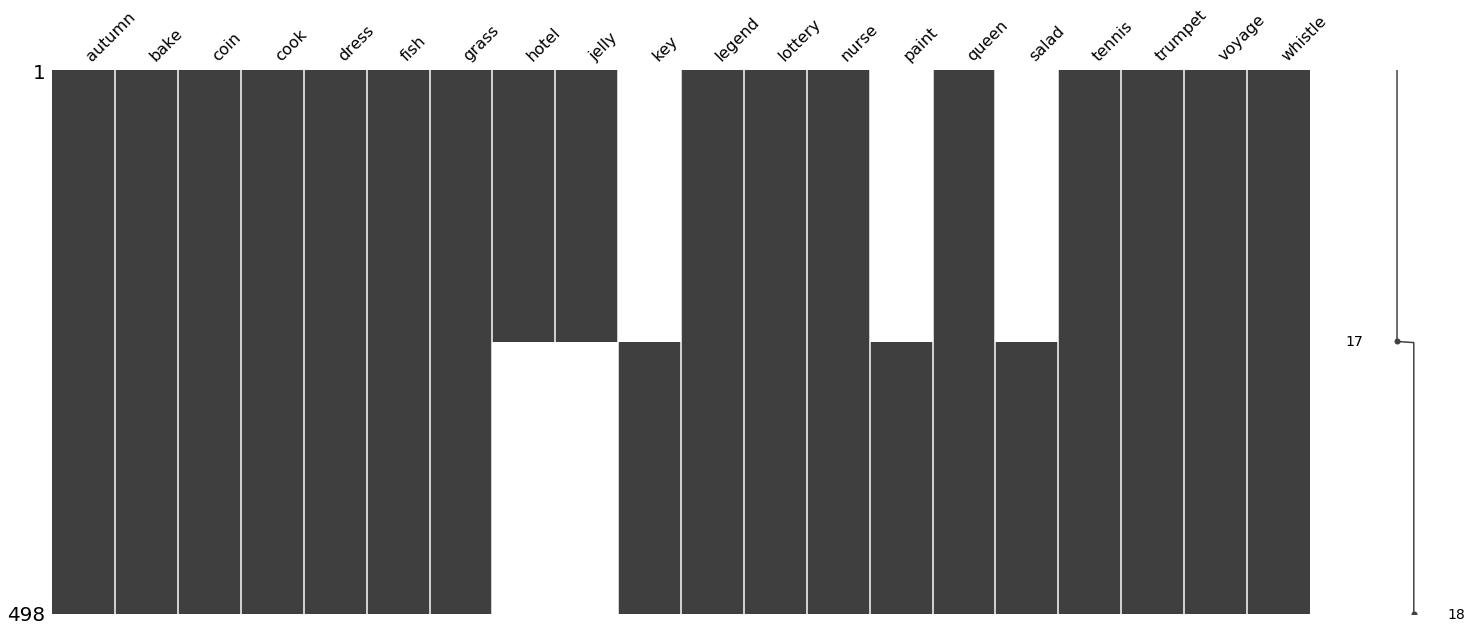

In [0]:
msgn.matrix(df_pos)

# Assembling our data table

In [0]:
features = pd.DataFrame()

features = pd.concat([features, data[['Age', 'Gender', 
                                      'PANAS_positive', 'PANAS_negative',
                                      'ANX_score','DEPRESSION_score','STRESS_score']]])

In [0]:
features.head(3)

,Age,Gender,PANAS_positive,PANAS_negative,ANX_score,DEPRESSION_score,STRESS_score
0,24,1,22,10,2,1,5
1,21,1,31,19,6,4,8
2,22,0,44,13,17,2,19


### Computing the mean Z score for negative, neutral and positive words

In [0]:
features['MEAN_sd_NEG'] = df_neg.mean(axis=1)
features['MEAN_sd_NEUT'] = df_neut.mean(axis=1)
features['MEAN_sd_POS'] = df_pos.mean(axis=1)

features['MEAN_abs_sd_NEG'] = df_neg.abs().mean(axis=1)
features['MEAN_abs_sd_NEUT'] = df_neut.abs().mean(axis=1)
features['MEAN_abs_sd_POS'] = df_pos.abs().mean(axis=1)

In [0]:
features['MEAN_sd_ALL'] = df.mean(axis=1)
features['MEAN_abs_sd_ALL'] = df.abs().mean(axis=1)

In [0]:
features.head(3)

,Age,Gender,PANAS_positive,PANAS_negative,ANX_score,DEPRESSION_score,STRESS_score,MEAN_sd_NEG,MEAN_sd_NEUT,MEAN_sd_POS,MEAN_abs_sd_NEG,MEAN_abs_sd_NEUT,MEAN_abs_sd_POS,MEAN_sd_ALL,MEAN_abs_sd_ALL
0,24,1,22,10,2,1,5,0.956269,0.555563,-0.286880,1.089297,0.945917,0.740513,1.355586,1.801502
1,21,1,31,19,6,4,8,0.031188,-0.106134,0.715452,0.642356,0.886749,0.998086,1.491543,2.103627
2,22,0,44,13,17,2,19,0.306218,0.763894,0.012458,1.938004,1.877084,1.417776,2.123563,3.326156


In [0]:
features.to_csv('Data_July_8_2018.csv', index=False)

---

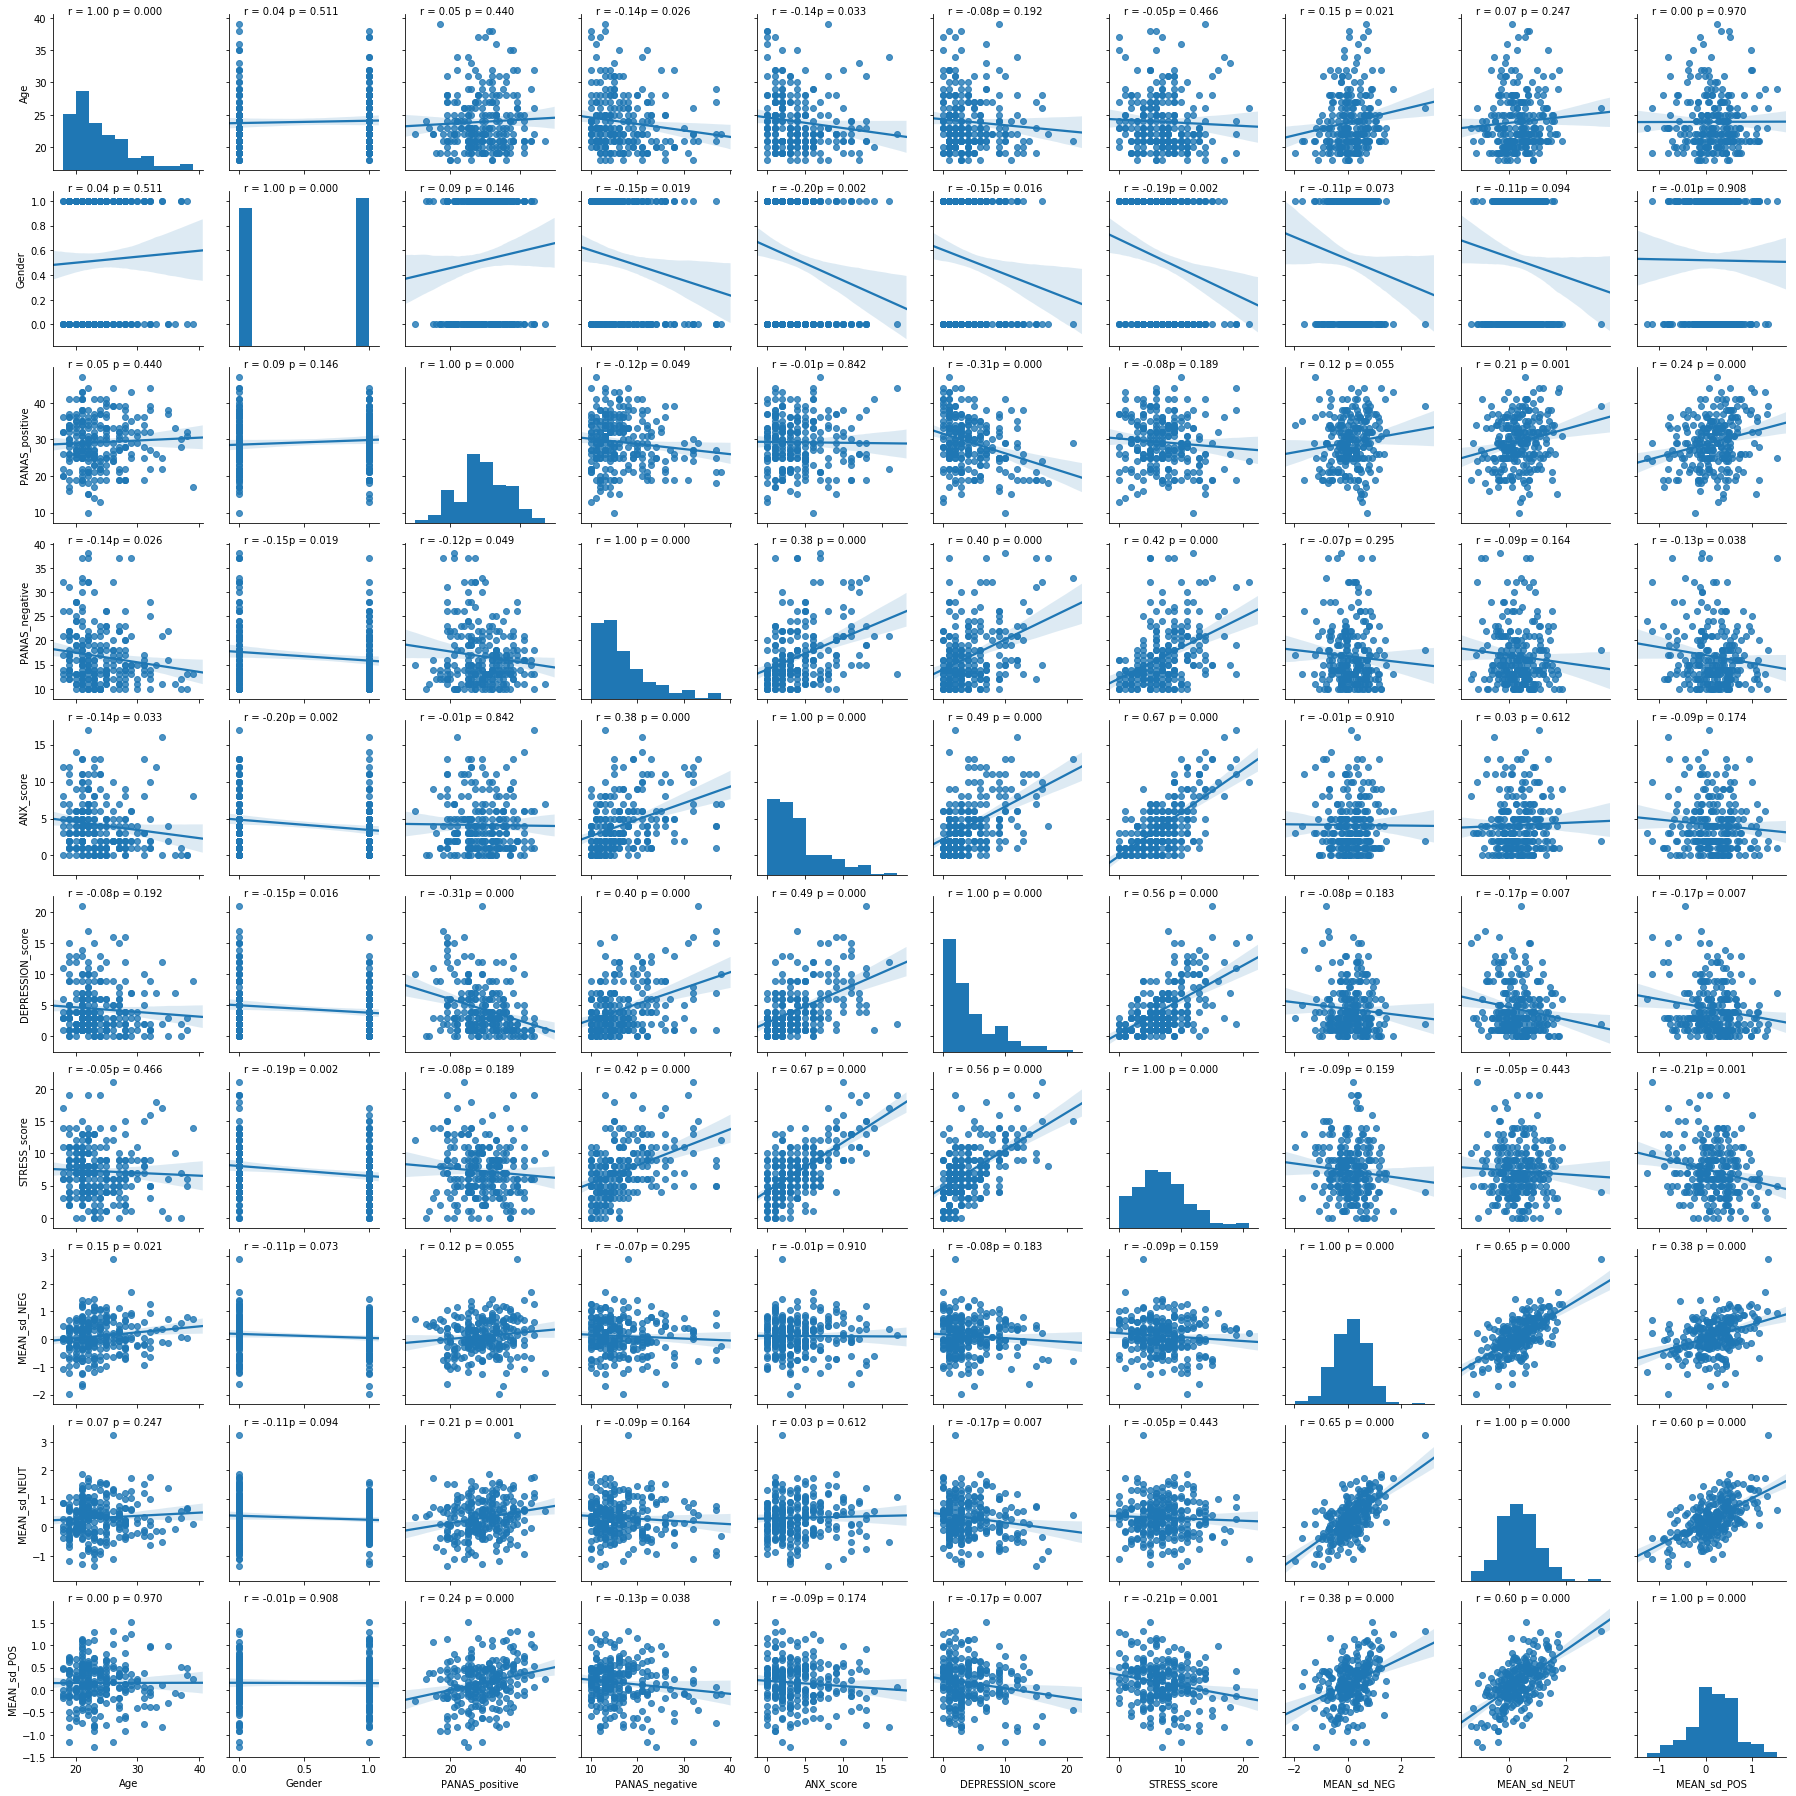

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f} ".format(r),
                xy=(.1, 1), xycoords=ax.transAxes)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.4, 1), xycoords=ax.transAxes)


graph = sns.pairplot(features, kind='reg')
graph.map(corrfunc)
plt.show()